In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

**Loading Partition 1.**

In [2]:
main_folder_path = "/home/afrid/Documents/NASA/dataverse_files/partition1"
folder_name_1 = 'FL'
folder_name_2 = 'NF'
folder_path_1 = os.path.join(main_folder_path, folder_name_1)
folder_path_2 = os.path.join(main_folder_path, folder_name_2)
files_folder_1 = os.listdir(folder_path_1)
files_folder_2 = os.listdir(folder_path_2)


In [3]:
dfs_folder_1 = [pd.read_csv(os.path.join(folder_path_1, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_folder_1]
dfs_folder_2 = [pd.read_csv(os.path.join(folder_path_2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_folder_2]

# Ensure the 'Class' column is of integer type
#for df in dfs_folder_1 + dfs_folder_2:
#    df['Class'] = df['Class'].astype(int)

In [4]:
data_folder_1 = np.stack([df.values for df in dfs_folder_1], axis=0)
data_folder_2 = np.stack([df.values for df in dfs_folder_2], axis=0)

print("Data types after loading CSV files:")
print(dfs_folder_1[0].dtypes)
print(dfs_folder_2[0].dtypes)

Data types after loading CSV files:
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object


In [5]:
data_folder_1[:, :, -1] = data_folder_1[:, :, -1].astype(int)
data_folder_2[:, :, -1] = data_folder_2[:, :, -1].astype(int)


print("Data types after conversion:")
print(data_folder_1[:, :, -1].dtype)
print(data_folder_2[:, :, -1].dtype)

Data types after conversion:
float64
float64


In [6]:
final_data = np.concatenate([data_folder_1, data_folder_2], axis=0)

In [7]:
fifth_subarray = data_folder_1[4]

missing_values_present = np.isnan(fifth_subarray).any()

if missing_values_present:
    print("Missing values present in the 5th subarray of data_folder_1.")
else:
    print("No missing values in the 5th subarray of data_folder_1.")


Missing values present in the 5th subarray of data_folder_1.


In [8]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    missing_values_present = np.isnan(subarray).any()
    if missing_values_present:
        subarrays_with_missing_values.append(i)

In [9]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    subarray = np.array(subarray)
    missing_values_present = np.isnan(subarray)
    if np.any(missing_values_present):
        subarrays_with_missing_values.append(i)
        column_means = np.nanmean(subarray, axis=0)
        for j in range(subarray.shape[1]):
            subarray[:, j][missing_values_present[:, j]] = column_means[j]
        final_data[i] = subarray.tolist()

In [10]:
missing_values_per_array = [
    np.any(np.isnan(array)) for array in final_data
]

In [11]:
data_folder_1.shape

(1254, 60, 4)

In [12]:
data_folder_2.shape

(72238, 60, 4)

In [13]:
final_data.shape

(73492, 60, 4)

**Loading Partition 2.**

In [14]:

main_folder_path_p2 = "/home/afrid/Documents/NASA/dataverse_files/partition2"
folder_name_FL_p2 = 'FL'
folder_name_NF_p2 = 'NF'

folder_path_FL_p2 = os.path.join(main_folder_path_p2, folder_name_FL_p2)
folder_path_NF_p2 = os.path.join(main_folder_path_p2, folder_name_NF_p2)
files_FL_p2 = os.listdir(folder_path_FL_p2)
files_NF_p2 = os.listdir(folder_path_NF_p2)


In [15]:
dfs_FL_p2 = [pd.read_csv(os.path.join(folder_path_FL_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_FL_p2]
dfs_NF_p2 = [pd.read_csv(os.path.join(folder_path_NF_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_NF_p2]
data_FL_p2 = np.stack([df.values for df in dfs_FL_p2], axis=0)
data_NF_p2 = np.stack([df.values for df in dfs_NF_p2], axis=0)
data_FL_p2[:, :, -1] = data_FL_p2[:, :, -1].astype(int)
data_NF_p2[:, :, -1] = data_NF_p2[:, :, -1].astype(int)

In [16]:
final_data_p2 = np.concatenate([data_FL_p2, data_NF_p2], axis=0)

In [17]:
subarrays_with_missing_values_NF_p2 = []

for i, subarray in enumerate(final_data_p2):
    subarray_NF_p2 = np.array(subarray)
    missing_values_present_NF_p2 = np.isnan(subarray_NF_p2)

    if np.any(missing_values_present_NF_p2):
        subarrays_with_missing_values_NF_p2.append(i)
        column_means_NF_p2 = np.nanmean(subarray_NF_p2, axis=0)
        for j_NF_p2 in range(subarray_NF_p2.shape[1]):
            subarray_NF_p2[:, j_NF_p2][missing_values_present_NF_p2[:, j_NF_p2]] = column_means_NF_p2[j_NF_p2]
        final_data_p2[i] = subarray_NF_p2.tolist()

**Sampling.**


partition 1

In [18]:

class_labels = final_data[:, 0, -1]
class_0_indices = np.where(class_labels == 0)[0]
class_1_indices = np.where(class_labels == 1)[0]
selected_class_0_indices = class_0_indices[:len(class_1_indices)]
selected_indices = np.concatenate([class_1_indices, selected_class_0_indices])
final_train_data = final_data[selected_indices]
final_train_data[:, 0, -1] = final_train_data[:, 0, -1].astype(int)

print(final_train_data.shape)

(2508, 60, 4)


Model Example.

In [66]:
X_train = final_train_data[:, :, :-1]
y_train = final_train_data[:, 0, -1]

X_test = final_data_p2[:, :, :-1]
y_test = final_data_p2[:, 0, -1]

In [67]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [68]:
y_test.shape

(88558,)

In [69]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2508, 60, 3)
(88558, 60, 3)
(2508,)
(88558,)


In [139]:
# Check for NaN values in X_train
nan_in_x_train = np.isnan(X_train)
any_nan_in_x_train = np.any(nan_in_x_train)

# Check for NaN values in X_test
nan_in_x_test = np.isnan(X_test)
any_nan_in_x_test = np.any(nan_in_x_test)

print(f'Any NaN in X_train: {any_nan_in_x_train}')
print(f'Any NaN in X_test: {any_nan_in_x_test}')

Any NaN in X_train: False
Any NaN in X_test: False


In [70]:
np.unique(y_test)


array([0, 1])

In [71]:
#X_train

In [72]:
scaler = RobustScaler()



In [73]:
'''def tss_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0'''

'def tss_score(estimator, X, y):\n    y_pred = estimator.predict(X)\n    cm = confusion_matrix(y, y_pred)\n    TN, FP, FN, TP = cm.ravel()\n    P = TP + FN\n    N = FP + TN\n    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0'

In [279]:
'''# Modify the tss_score function to take y_true and y_pred only
def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape[0] == cm.shape[1]:
        n_classes = cm.shape[0]
        tss_total = 0
        for i in range(n_classes):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - tp - fn - fp

            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            tss = sensitivity - (1 - specificity)

            tss_total += tss

        return tss_total / n_classes
    else:
        print("Error: Confusion matrix is not square.")
        return 0'''


'''def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape[0] == cm.shape[1]:
        n_classes = cm.shape[0]
        tss_total = 0
        for i in range(n_classes):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - tp - fn - fp

            sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
            #specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            #tss = sensitivity - (1 - specificity)
            fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
            tss = sensitivity - fpr

            tss_total += tss

        return tss_total #/ n_classes
    else:
        print("Error: Confusion matrix is not square.")
        return 0'''

def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tp = cm[1, 1]
        fn = cm[1, 0]
        fp = cm[0, 1]
        tn = cm[0, 0]

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tss = sensitivity - fpr

        return tss
    elif cm.shape == (1, 1):
        return 1 if y_true[0] == y_pred[0] else 0
    else:
        print(f"Error: Confusion matrix shape {cm.shape} is not handled.")
        return 0


custom_scorer = make_scorer(tss_score, greater_is_better=True)

In [346]:
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__n_windows': [5, 10, 15],
    'estimator__min_window_size': [1, 2],
    'estimator__criterion': ['entropy'],#, 'gini'],
    'estimator__max_depth': [5, 10, 20],
}

In [347]:
'''# Assuming X_train and X_test are 3D arrays with shape (n_samples, n_timestamps, n_features)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Now apply RobustScaler
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)'''


'# Assuming X_train and X_test are 3D arrays with shape (n_samples, n_timestamps, n_features)\nX_train_2d = X_train.reshape(X_train.shape[0], -1)\nX_test_2d = X_test.reshape(X_test.shape[0], -1)\n\n# Now apply RobustScaler\nX_train_scaled_2d = scaler.fit_transform(X_train_2d)\nX_test_scaled_2d = scaler.transform(X_test_2d)\n\n# Reshape back to 3D\nX_train_scaled = X_train_scaled_2d.reshape(X_train.shape)\nX_test_scaled = X_test_scaled_2d.reshape(X_test.shape)'

In [348]:
clf = MultivariateClassifier(estimator=TimeSeriesForest(random_state=53))

n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=custom_scorer, 
    refit='tss',
    cv=tscv,  
    n_jobs=-1,  
)

In [349]:

grid_search.fit(X_train, y_train)

/home/afrid/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=MultivariateClassifier(estimator=TimeSeriesForest(random_state=53)),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['entropy'],
                         'estimator__max_depth': [5, 10, 20],
                         'estimator__min_window_size': [1, 2],
                         'estimator__n_estimators': [100, 200, 300],
                         'estimator__n_windows': [5, 10, 15]},
             refit='tss', scoring=make_scorer(tss_score))

In [328]:
'''#clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, 
                                                        max_depth=5, 
                                                        min_window_size=2, 
                                                        random_state=53))
#clf.fit(X_train_scaled, y_train)'''

'#clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, \n                                                        max_depth=5, \n                                                        min_window_size=2, \n                                                        random_state=53))\n#clf.fit(X_train_scaled, y_train)'

In [350]:
for split_idx, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    print(f'Split {split_idx + 1}:')
    print(f'Training indices: {train_idx}')
    print(f'Testing indices: {test_idx}')
    print()

Split 1:
Training indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Testing indices: [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 2

In [351]:


for split_idx, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    X_train_split, X_test_split = X_train[train_idx], X_train[test_idx]
    y_train_split, y_test_split = y_train[train_idx], y_train[test_idx]
    grid_search.best_estimator_.fit(X_train_split, y_train_split)
    y_pred_split = grid_search.best_estimator_.predict(X_test_split)

    cm = confusion_matrix(y_test_split, y_pred_split)
    print(f'Confusion Matrix for Split {split_idx + 1}:\n{cm}')
    print()


Confusion Matrix for Split 1:
[[119]]

Confusion Matrix for Split 2:
[[119]]

Confusion Matrix for Split 3:
[[119]]

Confusion Matrix for Split 4:
[[119]]

Confusion Matrix for Split 5:
[[119]]

Confusion Matrix for Split 6:
[[119]]

Confusion Matrix for Split 7:
[[119]]

Confusion Matrix for Split 8:
[[119]]

Confusion Matrix for Split 9:
[[119]]

Confusion Matrix for Split 10:
[[ 0 64]
 [ 0 55]]

Confusion Matrix for Split 11:
[[80 39]
 [ 0  0]]

Confusion Matrix for Split 12:
[[92 27]
 [ 0  0]]

Confusion Matrix for Split 13:
[[90 29]
 [ 0  0]]

Confusion Matrix for Split 14:
[[88 31]
 [ 0  0]]

Confusion Matrix for Split 15:
[[94 25]
 [ 0  0]]

Confusion Matrix for Split 16:
[[101  18]
 [  0   0]]

Confusion Matrix for Split 17:
[[104  15]
 [  0   0]]

Confusion Matrix for Split 18:
[[108  11]
 [  0   0]]

Confusion Matrix for Split 19:
[[111   8]
 [  0   0]]

Confusion Matrix for Split 20:
[[102  17]
 [  0   0]]



In [352]:
indices_class_1 = [idx for idx, label in enumerate(y_train) if label == 1]
indices_class_0 = [idx for idx, label in enumerate(y_train) if label == 0]

print(f'Indices for class label 1: {indices_class_1}')
print(f'Indices for class label 0: {indices_class_0}')


Indices for class label 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

In [353]:
#y_pred = clf.predict(X_test_scaled)

In [354]:
results_df = pd.DataFrame(grid_search.cv_results_)

In [355]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__criterion', 'param_estimator__max_depth',
       'param_estimator__min_window_size', 'param_estimator__n_estimators',
       'param_estimator__n_windows', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'split10_test_score', 'split11_test_score', 'split12_test_score',
       'split13_test_score', 'split14_test_score', 'split15_test_score',
       'split16_test_score', 'split17_test_score', 'split18_test_score',
       'split19_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [359]:
print(results_df.iloc[:, 10:35].head().to_string())

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  split8_test_score  split9_test_score  split10_test_score  split11_test_score  split12_test_score  split13_test_score  split14_test_score  split15_test_score  split16_test_score  split17_test_score  split18_test_score  split19_test_score  mean_test_score  std_test_score  rank_test_score
0                1.0                1.0                1.0                1.0                1.0                1.0                1.0                1.0                1.0                0.0           -0.336134           -0.319328           -0.352941           -0.310924           -0.268908           -0.201681           -0.201681           -0.109244           -0.126050           -0.176471         0.329832        0.611271               43
1                1.0                1.0                1.0                1.0                1.0                1.0 

In [360]:
print(results_df.to_string())

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_estimator__criterion param_estimator__max_depth param_estimator__min_window_size param_estimator__n_estimators param_estimator__n_windows                                                                                                                                                        params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  split8_test_score  split9_test_score  split10_test_score  split11_test_score  split12_test_score  split13_test_score  split14_test_score  split15_test_score  split16_test_score  split17_test_score  split18_test_score  split19_test_score  mean_test_score  std_test_score  rank_test_score
0       17.662790     10.153676         0.933860        0.281462                    entropy                          5                                1                           100            

In [363]:

print("Best Parameters:", grid_search.best_params_)
print("Best TSS:", grid_search.best_score_)


Best Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 20, 'estimator__min_window_size': 1, 'estimator__n_estimators': 100, 'estimator__n_windows': 15}
Best TSS: 0.35756302521008404


In [364]:
grid_search.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 20,
 'estimator__min_window_size': 1,
 'estimator__n_estimators': 100,
 'estimator__n_windows': 15}

In [365]:
grid_search.best_score_

0.35756302521008404

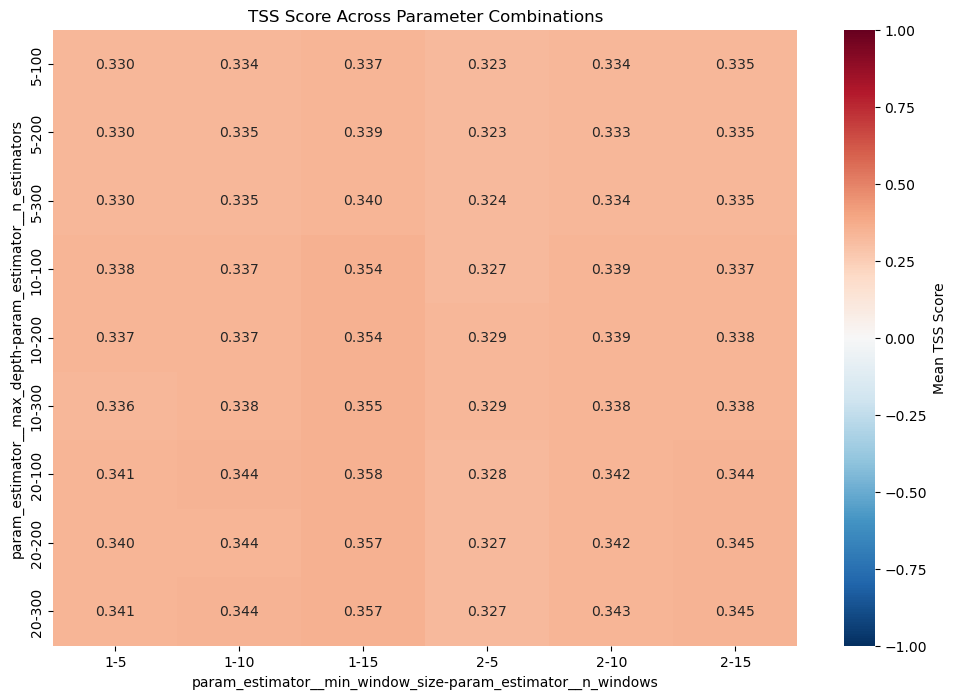

In [366]:
heatmap_data = results_df[['param_estimator__criterion', 'param_estimator__max_depth',
                            'param_estimator__min_window_size', 'param_estimator__n_estimators',
                            'param_estimator__n_windows', 'mean_test_score']]


heatmap_data_pivot = heatmap_data.pivot_table(index=['param_estimator__max_depth', 'param_estimator__n_estimators'],
                                              columns=['param_estimator__min_window_size', 'param_estimator__n_windows'],
                                              values='mean_test_score', aggfunc='mean')


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='RdBu_r', fmt=".3f", vmin=-1, vmax=1, cbar_kws={'label': 'Mean TSS Score'})
plt.title('TSS Score Across Parameter Combinations')
plt.show()


In [367]:
param_combinations = grid_search.cv_results_['params']
tss_values = grid_search.cv_results_['mean_test_score']

n_windows_values = [comb['estimator__n_windows'] for comb in param_combinations]
n_estimators_values = [comb['estimator__n_estimators'] for comb in param_combinations]

labels = [f"N Windows: {n_windows}, N Estimators: {n_estimators}, TSS: {tss}" 
          for n_windows, n_estimators, tss in zip(n_windows_values, n_estimators_values, tss_values)]

fig = go.Figure(data=[go.Scatter3d(x=n_windows_values, y=n_estimators_values, z=tss_values, mode='markers',
                                   marker=dict(color=tss_values, colorscale='Viridis', colorbar=dict(title='TSS')),
                                   text=labels, hoverinfo='text')])

fig.update_layout(scene=dict(xaxis_title='N Windows', yaxis_title='N Estimators', zaxis_title='TSS'))

fig.show()

In [88]:
def hss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (2 * ((TP * TN) - (FN * FP))) / ( (P * (FN + TN)) + (N * (TP + FP)) )

In [94]:
n_estimators_values = [100, 200, 300]
n_windows_values = [5]
max_depth_values = [None]

results = {"params": [], "tss_scores": [], "hss_scores": []}

for n_estimators in n_estimators_values:
    for n_windows in n_windows_values:
        for max_depth in max_depth_values:
            clf = MultivariateClassifier(estimator=TimeSeriesForest(
                n_estimators=n_estimators, n_windows=n_windows, max_depth=max_depth,random_state=53
            ))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tss = tss_score(y_test, y_pred)
            hss = hss_score(y_test, y_pred)
            results["params"].append({
                "n_estimators": n_estimators,
                "n_windows": n_windows,
                "max_depth": max_depth
            })
            results["tss_scores"].append(tss)
            results["hss_scores"].append(hss)
            print(f"Parameters: {results['params'][-1]}")
            print(f"TSS score: {tss:.3f}") 
            print(f"HSS score: {hss:.3f}\n")

Parameters: {'n_estimators': 100, 'n_windows': 5, 'max_depth': None}
TSS score: 0.744
HSS score: 0.139

Parameters: {'n_estimators': 200, 'n_windows': 5, 'max_depth': None}
TSS score: 0.740
HSS score: 0.138

Parameters: {'n_estimators': 300, 'n_windows': 5, 'max_depth': None}
TSS score: 0.743
HSS score: 0.138

